In [1]:
import os
import urllib
import hashlib
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.patches as patches
from sklearn.linear_model import LogisticRegression
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.patches as patches
import pytz

import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [2]:
years = range(2009, 2024)

In [3]:
for year in years:
    if not os.path.exists(f'../.cache/pbp/season={year}'):
        nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../.cache/pbp')

df_schedules = nfl.import_schedules(years)

df_stadiums_locs = pd.read_csv('../data/stadiums.csv')[['stadium_id','lat','lon','timezone']]

df_elevations = pd.read_csv('../data/stadium_elevation.csv')

cols = ['season','player_id','player_name','years_exp','draft_number','age']
df_rosters = nfl.import_seasonal_rosters(years)[cols]

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [9]:
# Columns to keep
variables = [
    'season', 'game_id', 'play_id', 'kicker_player_name', 'kicker_player_id', 
    'field_goal_attempt', 'field_goal_result', 'kick_distance', 'game_seconds_remaining',
    'game_half', 'season_type', 'posteam_type', 'roof', 'surface', 'wind', 'temp', 'stadium_id',
    'score_differential', 'timeout_prev_play', 'timeout_team_prev_play', 'posteam'
] # score_differential = posteam_score - defteam_score

# Sort by game_id and play_id and create columns for previous play's timeout and description
df_pbp = df_pbp.sort_values(['game_id', 'play_id'])
df_pbp['timeout_prev_play'] = df_pbp['timeout'].shift(1)
df_pbp['timeout_team_prev_play'] = df_pbp['timeout_team'].shift(1)
df_pbp['desc_prev_play'] = df_pbp['desc'].shift(1)

# Filter for field goal attempts
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

# Fix missing timeout team data for specific plays
fixes = {
    ('2013_07_SD_JAX', 2389.0): 'JAX',
    ('2015_09_JAX_NYJ', 2731.0): 'JAX'
}
for (game_id, play_id), team in fixes.items():
    df_fg.loc[(df_fg.play_id == play_id) & (df_fg.game_id == game_id), 'timeout_team_prev_play'] = team

# Determine if kicker was iced
df_fg['iced'] = np.where(
    (df_fg['timeout_prev_play'] == True) & (df_fg['posteam'] != df_fg['timeout_team_prev_play']), 
    1, 
    0
)

# Create binary columns for various conditions
df_fg['overtime'] = (df_fg['game_half'] == 'Overtime').astype(int)
df_fg['postseason'] = (df_fg['season_type'] == 'POST').astype(int)
df_fg['home_team'] = (df_fg['posteam_type'] == 'home').astype(int)
df_fg['grass_field'] = (df_fg['surface'] == 'grass').astype(int)
df_fg['grass_surface'] = df_fg['surface'].isin(['grass', 'grass ', 'dessograss']).astype(int)
df_fg['outdoors'] = (df_fg['roof'].isin(['outdoors', 'open'])).astype(int)

# Handle missing temperature and wind data
df_fg['temp'] = df_fg['temp'].fillna(70)
df_fg['wind'] = df_fg['wind'].fillna(0)

# Fill missing surface data based on the most common surface for each stadium
stadiums_with_surface = df_fg.query('surface == ""').stadium_id.unique()
for stadium_id in stadiums_with_surface:
    v_counts = df_fg.query('stadium_id == @stadium_id').surface.value_counts()
    surface = v_counts.index[0] 
    if (surface == "") & (len(v_counts) > 1):
        surface = v_counts.index[1]
    df_fg.loc[(df_fg.stadium_id == stadium_id) & (df_fg.surface == ""), 'surface'] = surface

# Special case for a specific stadium
df_fg.loc[df_fg.stadium_id == "GER00", 'surface'] = "dessograss"

# Merge stadium elevations
df_fg = df_fg.merge(df_elevations, how='left', on='stadium_id')

# Create a binary column for field goal made
df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

df_fg = df_fg.merge(df_schedules[['game_id', 'gameday', 'gametime']], on='game_id', how='left')

df_fg = df_fg.merge(df_stadiums_locs, how='left', on='stadium_id')

# Find the stadium elevation for the kicker's home stadium
home_stadiums = (df_schedules[['season', 'home_team', 'stadium_id']]
    .groupby(['season', 'home_team'])
    .agg(total=('stadium_id', 'count'), 
         home_stadium=('stadium_id', lambda x: x.value_counts().index[0]))
    .reset_index()
    .sort_values('total', ascending=True)
    [['season', 'home_team', 'home_stadium']]
    .merge(df_elevations, how='left', left_on='home_stadium', right_on='stadium_id')
    .drop(['stadium_id','home_stadium'], axis=1)
    .rename({'elevation':'home_stadium_elevation', 'home_team':'team'}, axis=1)
)
df_fg = df_fg.merge(home_stadiums, how='left', left_on=['season', 'posteam'], right_on=['season', 'team'])

df_fg['elevation_diff'] = df_fg['elevation'] - df_fg['home_stadium_elevation']

# Convert start time to datetime and convert to local time
def convert_timezone(row):
    return row['start_time'].tz_convert(pytz.timezone(row['timezone']))
df_fg['start_time'] = pd.to_datetime(df_fg.gameday + ' ' + df_fg.gametime, format='%Y-%m-%d %H:%M')
df_fg['start_time'] = df_fg['start_time'].dt.tz_localize(pytz.timezone('US/Eastern'))
df_fg['start_time'] = df_fg.apply(convert_timezone, axis=1)

# Join the roster data
df_fg = df_fg.merge(df_rosters, how='left', left_on=['season', 'kicker_player_id'], right_on=['season', 'player_id'])

pressure_situations = df_fg.overtime | \
    ((df_fg.score_differential <= 0) & (df_fg.score_differential >= -3) & (df_fg.game_seconds_remaining <= 500)) | \
    ((df_fg.postseason == 1) & (df_fg.score_differential <= 0) & (df_fg.score_differential >= -3)) | \
    (df_fg.iced == 1)

df_fg['pressure_situation'] = pressure_situations.astype(int)

# Drop unnecessary columns
drop_cols = [
    'kicker_player_name','game_half', 'season_type', 'posteam_type', 'surface', 'roof',
    'timeout_prev_play', 'timeout_team_prev_play', 'field_goal_result', 
    'field_goal_attempt', 'stadium_id', 'gameday', 'gametime', 'lat', 'lon', 'timezone', 'home_stadium_elevation',
    'start_time', 'player_id', 'team', 'posteam'
]

# Reorder columns
df_fg = df_fg[df_fg.columns.drop('player_name').insert(df_fg.columns.get_loc('kicker_player_id') - 1, 'player_name')]
df_fg = df_fg[df_fg.columns.drop('field_goal_made').insert(len(df_fg.columns)-1, 'field_goal_made')]
df_fg = df_fg[df_fg.columns.drop('years_exp').insert(df_fg.columns.get_loc('kicker_player_id') + 1, 'years_exp')]
df_fg = df_fg[df_fg.columns.drop('draft_number').insert(df_fg.columns.get_loc('kicker_player_id') + 2, 'draft_number')]
df_fg = df_fg[df_fg.columns.drop('age').insert(df_fg.columns.get_loc('kicker_player_id') + 3, 'age')]

df_fg = df_fg.drop(drop_cols, axis=1)

In [10]:
df_fg.head()

,season,game_id,play_id,player_name,kicker_player_id,years_exp,draft_number,age,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,outdoors,elevation,elevation_diff,pressure_situation,field_goal_made
0,2009,2009_01_BUF_NE,595.0,Stephen Gostkowski,00-0024333,3.0,118,25.0,41.0,3082.0,5.0,70.0,0.0,0,0,0,1,0,0,1,78,0.0,0,0
1,2009,2009_01_BUF_NE,2009.0,Stephen Gostkowski,00-0024333,3.0,118,25.0,20.0,1805.0,5.0,70.0,-7.0,0,0,0,1,0,0,1,78,0.0,0,1
2,2009,2009_01_BUF_NE,2736.0,Rian Lindell,00-0019310,9.0,None,32.0,40.0,1057.0,5.0,70.0,4.0,0,0,0,0,0,0,1,78,-154.0,0,1
3,2009,2009_01_BUF_NE,3074.0,Stephen Gostkowski,00-0024333,3.0,118,25.0,28.0,707.0,5.0,70.0,-7.0,0,0,0,1,0,0,1,78,0.0,0,1
4,2009,2009_01_CHI_GB,192.0,Mason Crosby,00-0025580,2.0,193,24.0,49.0,3404.0,0.0,76.0,0.0,0,0,0,1,1,1,1,193,0.0,0,0


In [24]:
#count the number of field goals attempted and made by distance
df_binom = df_fg.groupby('kick_distance').agg({'game_id':'count','field_goal_made':'sum'}).reset_index()
df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
              .rename({'game_id':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

df_binom['fg_pct'] = df_binom['field_goal_makes'] / df_binom['field_goal_attempts']
df_binom.head()

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,18,18,1.000000
1,19.0,131,131,1.000000
2,20.0,281,279,0.992883
3,21.0,317,312,0.984227
4,22.0,386,379,0.981865


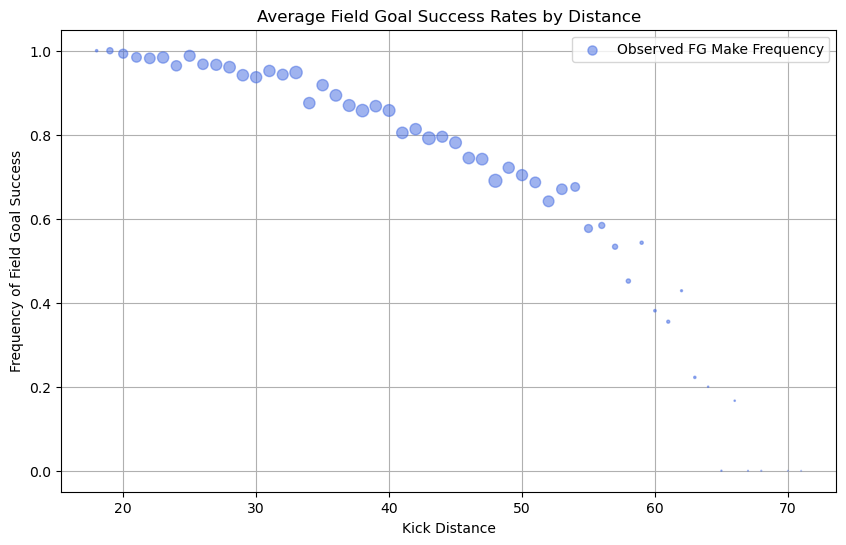

In [25]:
import matplotlib.pyplot as plt

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot
ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Frequency of Field Goal Success')
ax.set_title('Average Field Goal Success Rates by Distance')
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Add gridlines
ax.grid()

# Show the plot
plt.show()

fig.savefig('../images/fg_obs_data.png', bbox_inches='tight', dpi=300)

/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


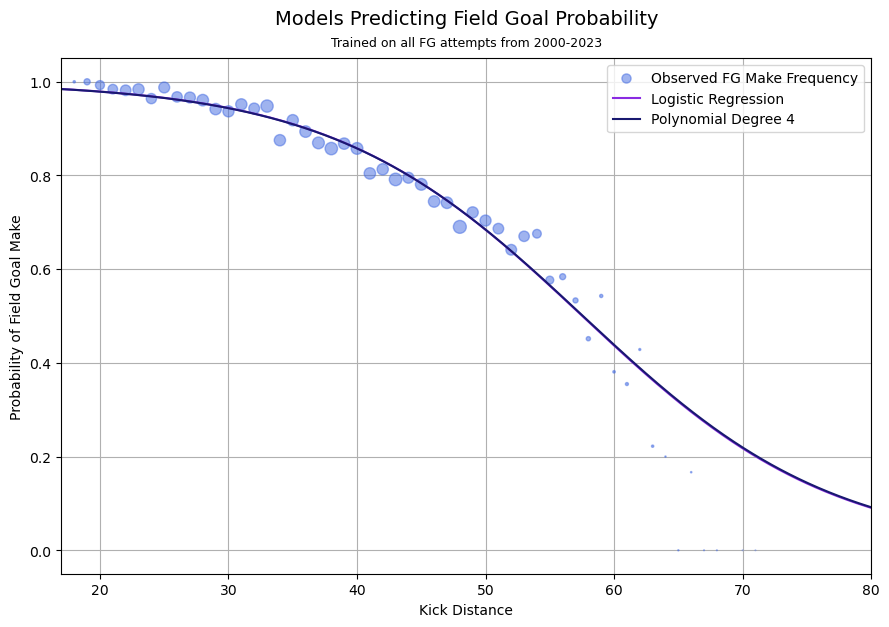

In [33]:
# Fit logistic regression model
X = df_fg[['kick_distance']]
y = df_fg['field_goal_made']
model = LogisticRegression()
model.fit(X, y)

# Fit polynomial logistic regression model
degree = 1
model_poly_4 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_4.fit(X, y)

# Generate values for plotting
x_values = np.linspace(0, 80, 1000)

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6.5))

# Plot the scatter plot
ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Plot logistic regression predictions
y_values = model.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='blueviolet', label='Logistic Regression')

# Plot polynomial logistic regression predictions
y_values = model_poly_4.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='midnightblue', label='Polynomial Degree 4')

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Probability of Field Goal Make')
ax.set_title('Models Predicting Field Goal Probability', y=1.05, fontsize=14)

# add smaller text below title
ax.text(0.5, 1.03, 'Trained on all FG attempts from 2000-2023', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)

# Set legend
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Limit x axis to 17 to 80
ax.set_xlim([17, 80])

# Add gridlines
ax.grid()

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for subtitle
plt.show()

fig.savefig('../images/logit_and_poly_fg_model_fits.png', bbox_inches='tight', dpi=300)

In [27]:
df_fg['fg_proba'] = model_poly_4.predict_proba(df_fg[['kick_distance']])[:,1]

In [ ]:
summary = df_fg.groupby(['kicker_player_id']).agg(
    earliest_season=('season', 'min'),
    latest_season=('season', 'max'),
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

In [ ]:
df_headshots = nfl.import_seasonal_rosters(years, columns=['season','player_name','player_id','headshot_url'])
df_headshots.sort_values(by='season', ascending=False, inplace=True)
df_headshots.drop_duplicates(subset='player_id', keep='first', inplace=True)
df_kickers = summary.merge(df_headshots, left_on='kicker_player_id', right_on='player_id', how='left')
df_kickers.head()

,kicker_player_id,earliest_season,latest_season,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation,season,player_name,player_id,headshot_url
0,00-0000108,2000,2013,422,516,434.959312,0.817829,0.842944,-0.025115,2013,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...
1,00-0000282,2000,2007,151,182,154.536630,0.829670,0.849102,-0.019432,2007,Morten Andersen,00-0000282,https://static.www.nfl.com/image/private/f_aut...
2,00-0000313,2000,2004,103,122,103.909426,0.844262,0.851717,-0.007454,2004,Gary Anderson,00-0000313,https://static.www.nfl.com/image/private/f_aut...
3,00-0001138,2000,2000,1,1,0.671025,1.000000,0.671025,0.328975,2000,Scott Bentley,00-0001138,https://static.www.nfl.com/image/private/f_aut...
4,00-0001343,2000,2000,16,23,19.028847,0.695652,0.827341,-0.131689,2001,Cary Blanchard,00-0001343,https://static.www.nfl.com/image/private/f_aut...


In [ ]:
cols = ['player_name','headshot_url','total_attempts','actual_fg_pct','expected_fg_pct', 'fg_pct_over_expectation']
df_kickers = df_kickers[cols]

# fill missing headshot urls with a default image
default_img_url = 'https://static.www.nfl.com/image/private/f_auto,q_auto/league/rtnc0qkvhmkcwwueac0o'
df_kickers.headshot_url = df_kickers.headshot_url.fillna(default_img_url)

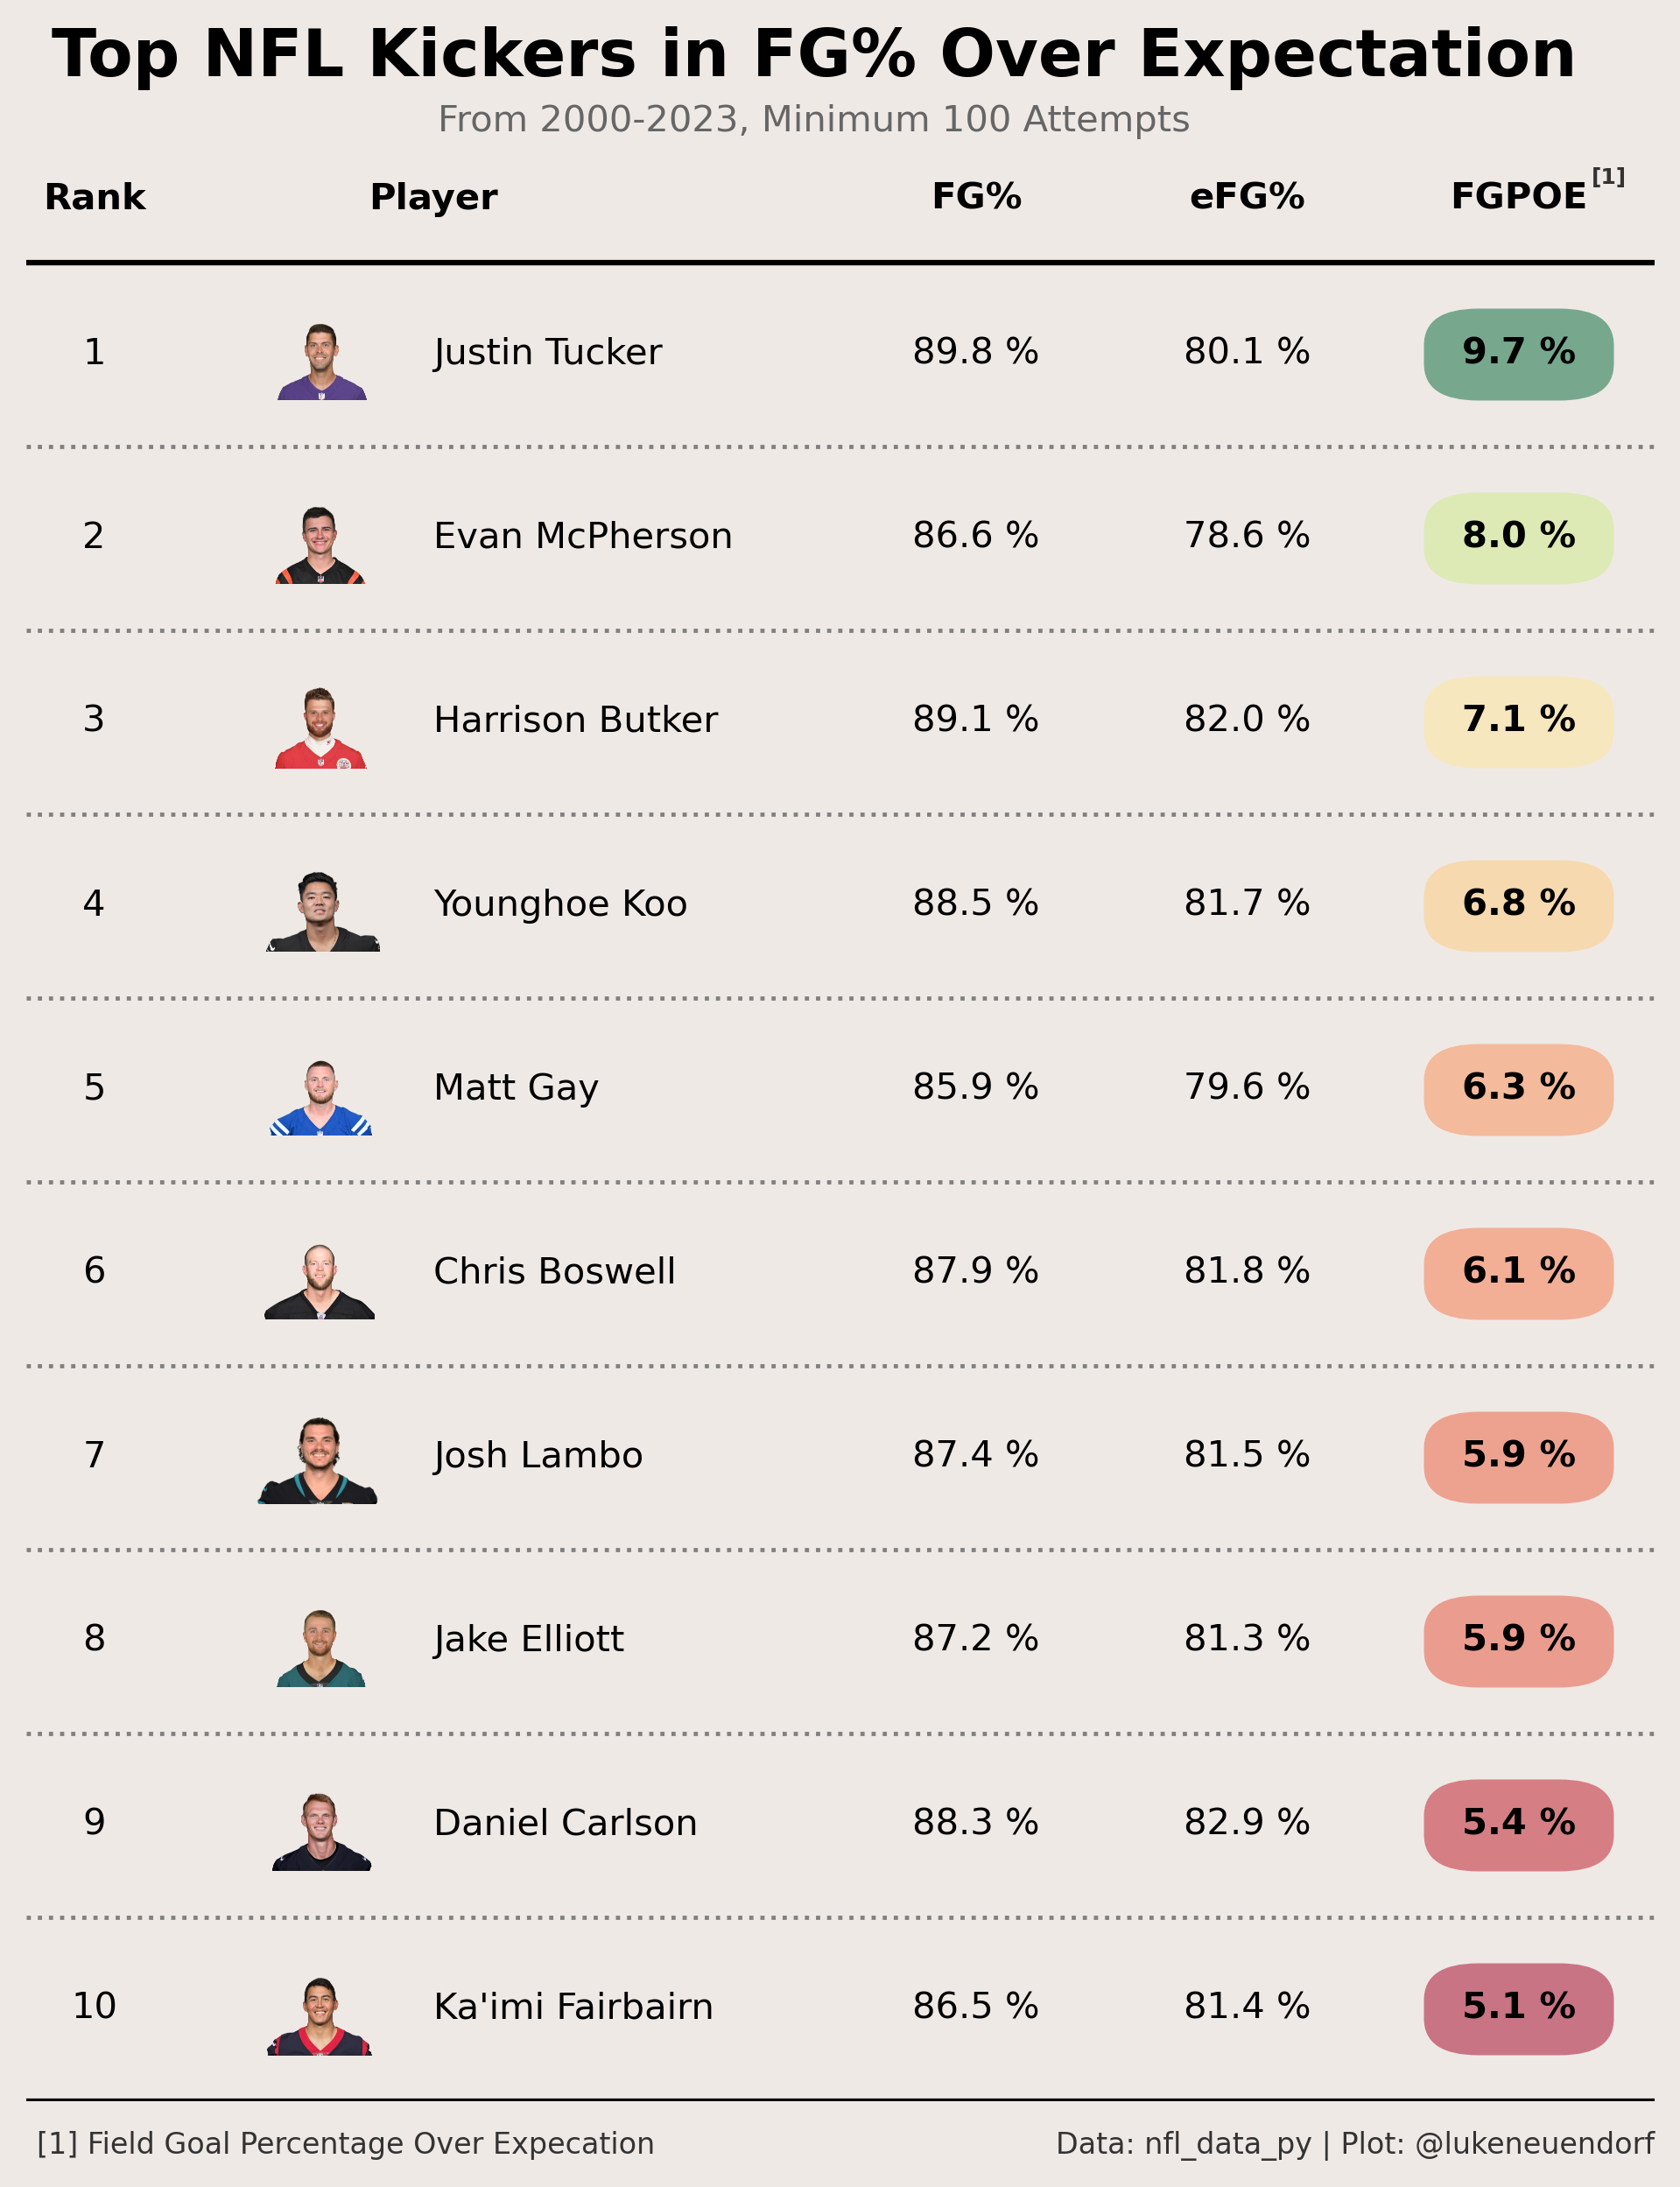

In [ ]:
cache_dir = '../.cache/headshots'

os.makedirs(cache_dir, exist_ok=True)

# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players)
                  .reset_index(drop=True)
                  .reset_index()
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def cache_image(url, cache_dir):
    """
    Downloads the image from the URL and saves it to the cache directory if not already cached.
    Returns the local file path of the cached image.
    """
    # Create a unique filename based on the URL using a hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    file_extension = url.split('.')[-1]
    # Check if the extension is reasonable, otherwise default to 'png'
    if file_extension.lower() not in ['jpg', 'jpeg', 'png']:
        file_extension = 'png'
    local_filename = f"{url_hash}.{file_extension}"
    local_path = os.path.join(cache_dir, local_filename)
    
    # Download the image if it does not exist in the cache
    if not os.path.exists(local_path):
        try:
            print(f"Downloading image from {url}")
            urllib.request.urlretrieve(url, local_path)
        except Exception as e:
            print(f"Failed to download image from {url}: {e}")
            # Provide a path to a default placeholder image
            local_path = 'default_placeholder_image.png'  # Ensure this file exists
    
    return local_path

def ax_logo(url, ax):
    # Get the local file path from the cache
    local_path = cache_image(url, cache_dir)
    
    try:
        headshot = Image.open(local_path)
        ax.imshow(headshot)
    except FileNotFoundError:
        print(f"File not found: {local_path}")
        # Optionally, you could add a placeholder or leave it empty if the image is missing.
        ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=10, color='red')
    
    ax.axis('off')
    return ax


# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.83, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='black', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Minimum 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

# save to ../images
fig.savefig('../images/fg_pct_over_expectation_t10.png', bbox_inches='tight', dpi=300)

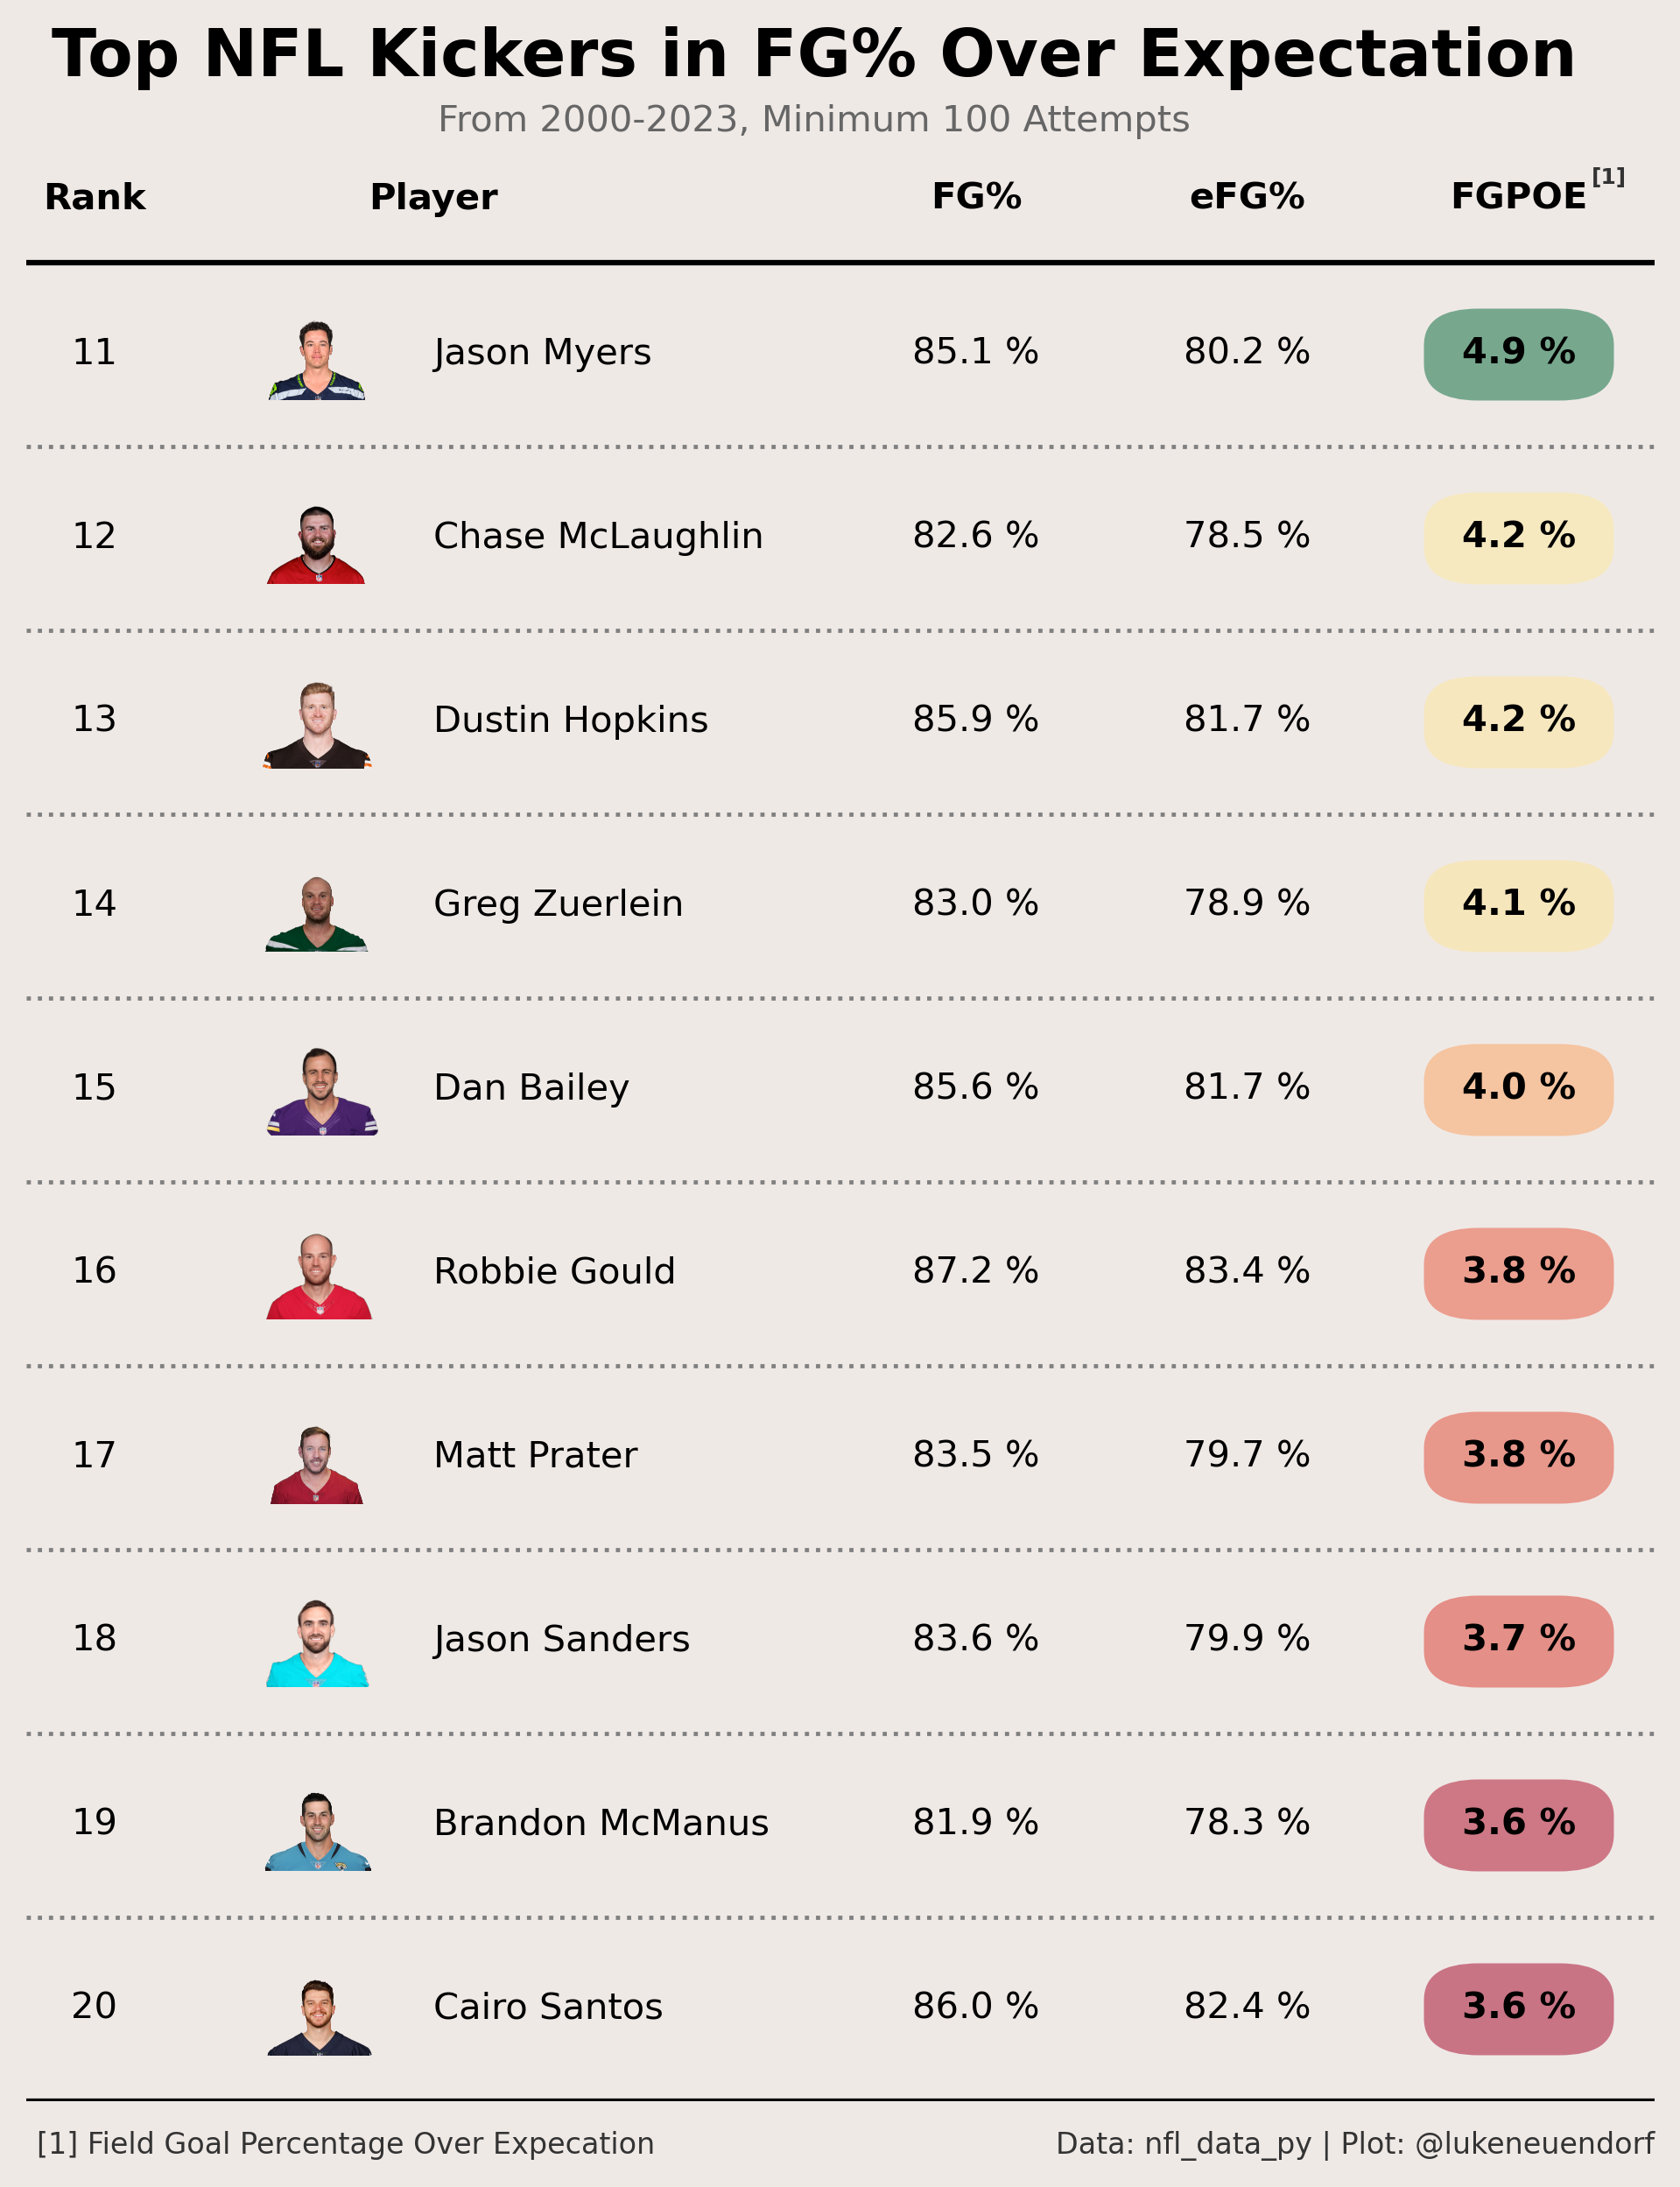

In [ ]:
# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players + 10)
                  .reset_index(drop=True)
                  .reset_index()
                  .iloc[10:,:]  # Skip the top 10
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def cache_image(url, cache_dir):
    """
    Downloads the image from the URL and saves it to the cache directory if not already cached.
    Returns the local file path of the cached image.
    """
    # Create a unique filename based on the URL using a hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    file_extension = url.split('.')[-1]
    # Check if the extension is reasonable, otherwise default to 'png'
    if file_extension.lower() not in ['jpg', 'jpeg', 'png']:
        file_extension = 'png'
    local_filename = f"{url_hash}.{file_extension}"
    local_path = os.path.join(cache_dir, local_filename)
    
    # Download the image if it does not exist in the cache
    if not os.path.exists(local_path):
        try:
            print(f"Downloading image from {url}")
            urllib.request.urlretrieve(url, local_path)
        except Exception as e:
            print(f"Failed to download image from {url}: {e}")
            # Provide a path to a default placeholder image
            local_path = 'default_placeholder_image.png'  # Ensure this file exists
    
    return local_path

def ax_logo(url, ax):
    # Get the local file path from the cache
    local_path = cache_image(url, cache_dir)
    
    try:
        headshot = Image.open(local_path)
        ax.imshow(headshot)
    except FileNotFoundError:
        print(f"File not found: {local_path}")
        # Optionally, you could add a placeholder or leave it empty if the image is missing.
        ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=10, color='red')
    
    ax.axis('off')
    return ax

# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.82, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='black', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Minimum 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

fig.savefig('../images/fg_pct_over_expectation_t20.png', bbox_inches='tight', dpi=300)

In [ ]:
df_fg.head()

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba
0,2000,2000_01_ARI_NYG,2771.0,C.Blanchard,00-0001343,32.0,905.0,3.0,80.0,-14.0,0,0,0,0,1,1,2,1,0.916383
1,2000,2000_01_BAL_PIT,467.0,M.Stover,00-0015784,23.0,3201.0,8.0,74.0,0.0,0,0,0,0,0,0,223,1,0.976624
2,2000,2000_01_BAL_PIT,1810.0,M.Stover,00-0015784,26.0,1811.0,8.0,74.0,10.0,0,0,0,0,0,0,223,1,0.964119
3,2000,2000_01_BAL_PIT,2027.0,M.Stover,00-0015784,33.0,1800.0,8.0,74.0,13.0,0,0,0,0,0,0,223,1,0.905149
4,2000,2000_01_BAL_PIT,2250.0,K.Brown,00-0001980,45.0,1591.0,8.0,74.0,-16.0,0,0,0,1,0,0,223,0,0.740813


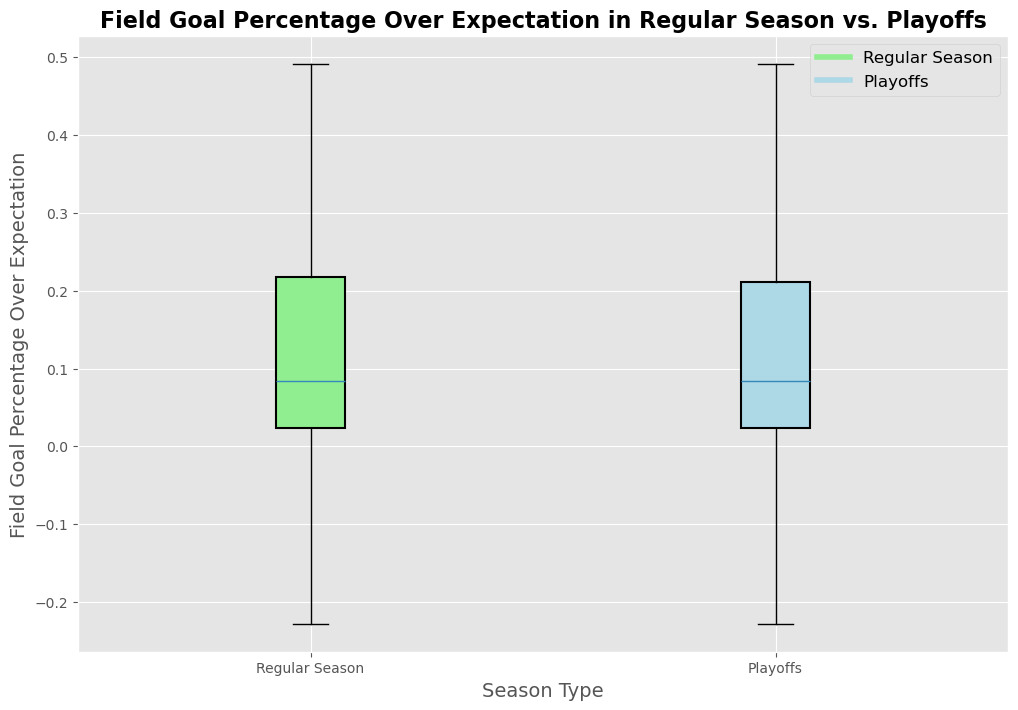

In [ ]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
playoffs = df_fg.query('postseason == 1')
regular_season = df_fg.query('postseason == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [regular_season['fg_pct_over_expectation'], playoffs['fg_pct_over_expectation']],
    tick_labels=['Regular Season', 'Playoffs'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation in Regular Season vs. Playoffs', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)
ax.set_xlabel('Season Type', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Regular Season'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Playoffs')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

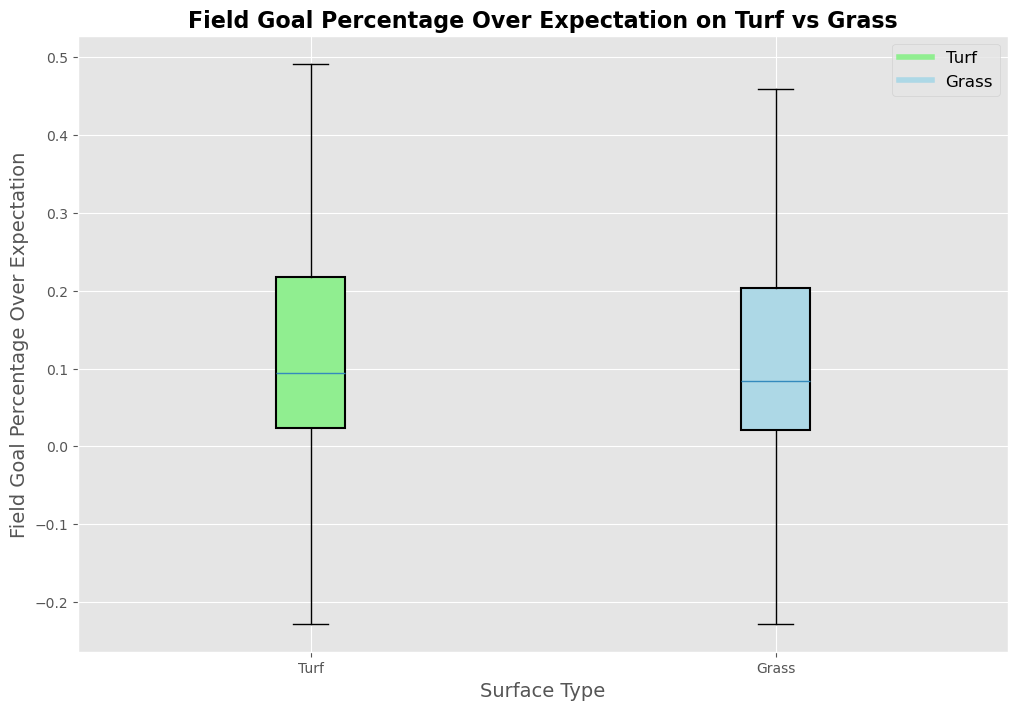

In [ ]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
grass = df_fg.query('grass_surface == 1')
turf = df_fg.query('grass_surface == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [turf['fg_pct_over_expectation'], grass['fg_pct_over_expectation']],
    tick_labels=['Turf', 'Grass'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation on Turf vs Grass', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)
ax.set_xlabel('Surface Type', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Turf'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Grass')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

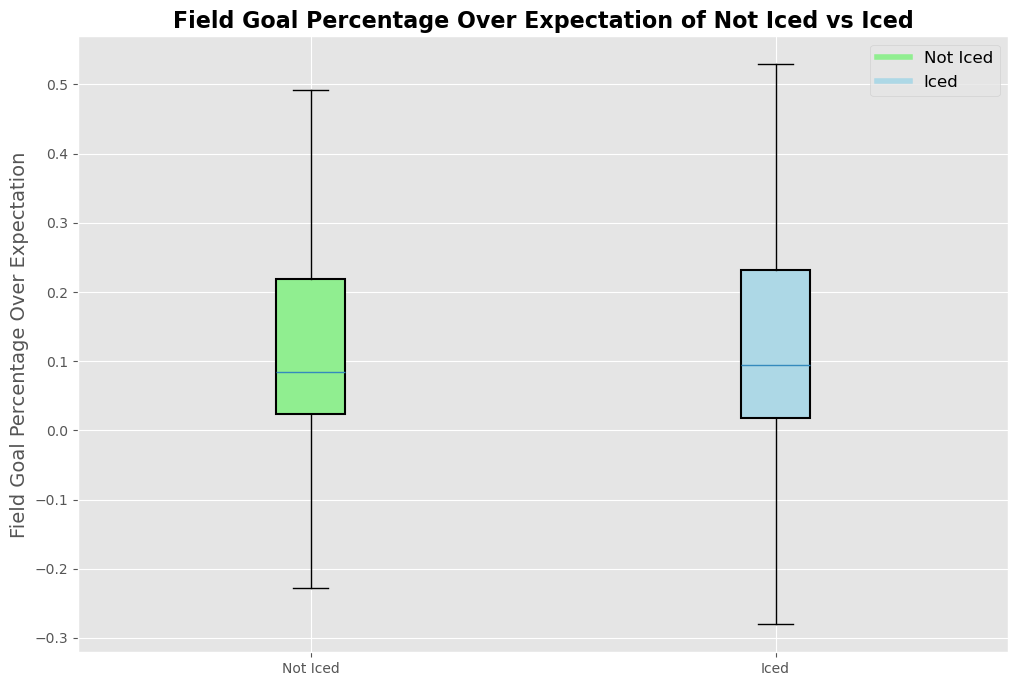

In [ ]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
iced = df_fg.query('iced == 1')
not_iced = df_fg.query('iced == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_iced['fg_pct_over_expectation'], iced['fg_pct_over_expectation']],
    tick_labels=['Not Iced', 'Iced'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Iced vs Iced', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Iced'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Iced')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

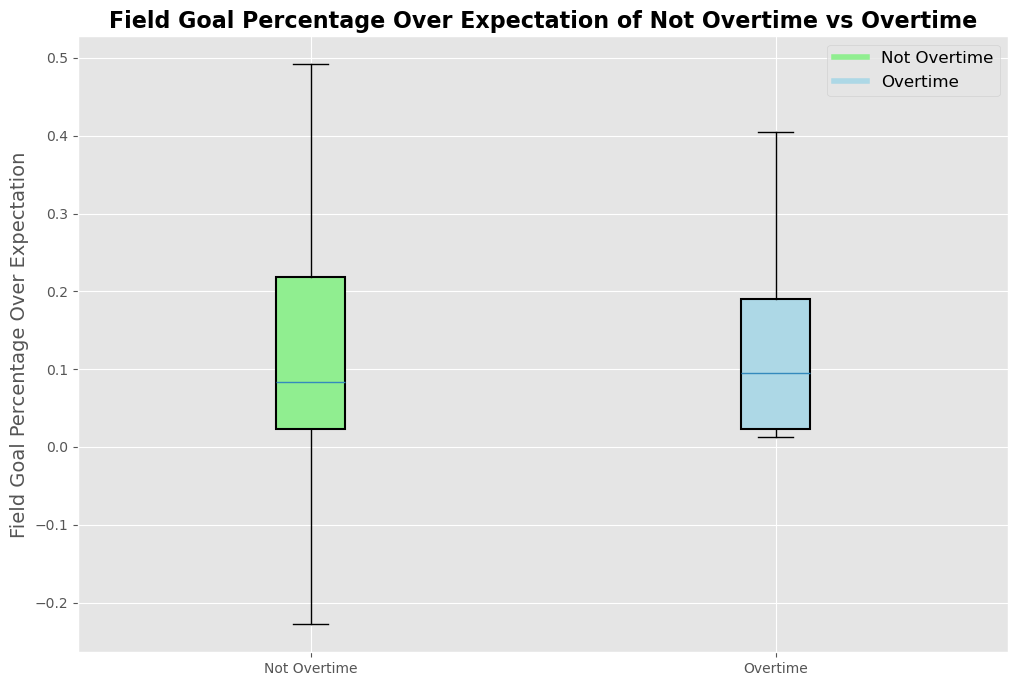

In [ ]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
overtime = df_fg.query('overtime == 1')
not_overtime = df_fg.query('overtime == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_overtime['fg_pct_over_expectation'], overtime['fg_pct_over_expectation']],
    tick_labels=['Not Overtime', 'Overtime'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Overtime vs Overtime', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Overtime'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Overtime')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

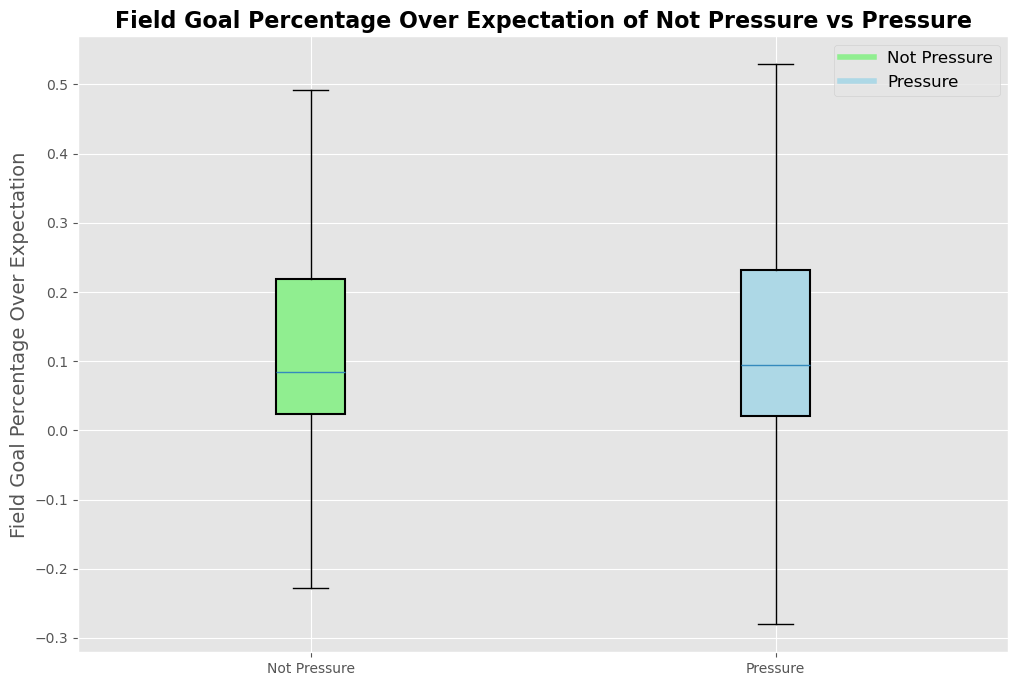

In [ ]:
plt.style.use('ggplot')

# Calculate standard deviation of the field goal percentage over expectation
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']
pressure_situation = df_fg.query('pressure_situation == 1')
not_pressure_situation = df_fg.query('pressure_situation == 0')

# Create boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bp = ax.boxplot(
    [not_pressure_situation['fg_pct_over_expectation'], pressure_situation['fg_pct_over_expectation']],
    tick_labels=['Not Pressure', 'Pressure'],  # Use 'tick_labels' instead of 'labels'
    patch_artist=True,
    showfliers=False
)

# Set colors
colors = ['lightgreen', 'lightblue']  # Pastel colors for the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

# Add title and labels
ax.set_title('Field Goal Percentage Over Expectation of Not Pressure vs Pressure', fontsize=16, fontweight='bold')
ax.set_ylabel('Field Goal Percentage Over Expectation', fontsize=14)

# Adding a legend
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='Not Pressure'),
    plt.Line2D([0], [0], color=colors[1], lw=4, label='Pressure')
]
ax.legend(handles=handles, loc='upper right', fontsize=12)

# Show plot
plt.show()

In [ ]:
df_fg.sort_values(['game_id', 'play_id'], inplace=True, ignore_index=True)

# Calculate the field goal percentage over expectation for each kicker for their last n kicks
df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']

# Function to calculate rolling mean excluding the current row
def rolling_mean_exclude_current(x, n):
    return x.rolling(window = n, min_periods=n).mean().shift(1)

df_fg['FGPOE_L10'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 10))
df_fg['FGPOE_L20'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 20))
df_fg['FGPOE_L30'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 30))
df_fg['FGPOE_L35'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 35))
df_fg['FGPOE_L40'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 40))
df_fg['FGPOE_L50'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 50))
df_fg['FGPOE_L75'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 75))
df_fg['FGPOE_L100'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 100))


def expanding_mean_exclude_current(x):
    return x.expanding(min_periods=25).mean().shift(1)

# Calculate career average of all kicks prior to each kick
df_fg['career_fg_pct_over_expectation'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(expanding_mean_exclude_current)

In [ ]:

print('L10:', round(df_fg.query('season >= 2010').FGPOE_L10.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L20:', round(df_fg.query('season >= 2010').FGPOE_L20.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L30:', round(df_fg.query('season >= 2010').FGPOE_L30.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L35:', round(df_fg.query('season >= 2010').FGPOE_L35.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L40:', round(df_fg.query('season >= 2010').FGPOE_L40.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L50:', round(df_fg.query('season >= 2010').FGPOE_L50.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L75:', round(df_fg.query('season >= 2010').FGPOE_L75.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))
print('L100:', round(df_fg.query('season >= 2010').FGPOE_L100.isna().sum() / df_fg.query('season >= 2010').shape[0]*100,2))


L10: 4.9
L20: 8.85
L30: 12.56
L35: 14.42
L40: 16.14
L50: 19.33
L75: 26.73
L100: 34.03


In [ ]:
df_fg.query('season==2023').kicker_player_name.value_counts()

kicker_player_name
H.Butker        46
J.Myers         42
M.Gay           41
J.Tucker        40
B.Aubrey        39
G.Zuerlein      38
C.Santos        38
Y.Koo           37
B.McManus       37
B.Grupe         37
C.McLaughlin    36
D.Hopkins       36
A.Carlson       36
W.Lutz          34
T.Bass          34
J.Elliott       33
J.Moody         33
C.Dicker        33
M.Prater        33
C.Boswell       32
K.Fairbairn     31
E.McPherson     31
D.Carlson       30
N.Folk          30
G.Joseph        30
E.Pineiro       29
J.Sanders       28
B.Maher         26
C.Ryland        25
J.Slye          24
L.Havrisik      20
R.Patterson     18
G.Gano          17
M.Ammendola      9
M.Badgley        7
M.Crosby         7
R.Bullock        6
A.Seibert        1
D.Ogunbowale     1
J.Gillan         1
M.Wright         1
Name: count, dtype: int64

In [ ]:
df_fg.query('kicker_player_name == "B.Aubrey"')

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba,fg_pct_over_expectation,pressure_situation,FGPOE_L10,FGPOE_L20,FGPOE_L30,FGPOE_L40,FGPOE_L50,FGPOE_L75,FGPOE_L100,FGPOE_L35,career_fg_pct_over_expectation
23383,2023,2023_01_DAL_NYG,704.0,B.Aubrey,00-0037692,21.0,2904.0,0.0,70.0,6.0,1,0,0,0,0,0,2,1,0.981959,0.018041,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23384,2023,2023_01_DAL_NYG,1256.0,B.Aubrey,00-0037692,38.0,2460.0,0.0,70.0,16.0,0,0,0,0,0,0,2,1,0.838848,0.161152,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23479,2023,2023_02_NYJ_DAL,1162.0,B.Aubrey,00-0037692,35.0,2354.0,0.0,70.0,7.0,0,0,0,1,0,0,173,1,0.880282,0.119718,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23481,2023,2023_02_NYJ_DAL,2650.0,B.Aubrey,00-0037692,21.0,1347.0,0.0,70.0,8.0,0,0,0,1,0,0,173,1,0.981959,0.018041,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23482,2023,2023_02_NYJ_DAL,2872.0,B.Aubrey,00-0037692,55.0,1224.0,0.0,70.0,11.0,0,0,0,1,0,0,173,1,0.569928,0.430072,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23483,2023,2023_02_NYJ_DAL,3324.0,B.Aubrey,00-0037692,26.0,747.0,0.0,70.0,14.0,0,0,0,1,0,0,173,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23484,2023,2023_02_NYJ_DAL,3616.0,B.Aubrey,00-0037692,30.0,502.0,0.0,70.0,17.0,0,0,0,1,0,0,173,1,0.936077,0.063923,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23522,2023,2023_03_DAL_ARI,908.0,B.Aubrey,00-0037692,49.0,2812.0,0.0,70.0,-9.0,0,0,0,0,1,1,326,1,0.686036,0.313964,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23525,2023,2023_03_DAL_ARI,2852.0,B.Aubrey,00-0037692,27.0,1470.0,0.0,70.0,-11.0,0,0,0,0,1,1,326,1,0.958454,0.041546,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23526,2023,2023_03_DAL_ARI,3810.0,B.Aubrey,00-0037692,26.0,576.0,0.0,70.0,-8.0,0,0,0,0,1,1,326,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
round(df_fg.query('kicker_player_name == "B.Aubrey"').iloc[:-3].fg_pct_over_expectation.mean(),6)

0.155061

In [ ]:
df_fg.head()

,season,game_id,play_id,kicker_player_name,kicker_player_id,kick_distance,game_seconds_remaining,wind,temp,score_differential,iced,overtime,postseason,home_team,grass_field,grass_surface,elevation,field_goal_made,fg_proba,fg_pct_over_expectation,pressure_situation,FGPOE_L10,FGPOE_L20,FGPOE_L30,FGPOE_L40,FGPOE_L50,FGPOE_L75,FGPOE_L100,FGPOE_L35,career_fg_pct_over_expectation
0,2000,2000_01_ARI_NYG,2771.0,C.Blanchard,00-0001343,32.0,905.0,3.0,80.0,-14.0,0,0,0,0,1,1,2,1,0.916383,0.083617,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2000_01_BAL_PIT,467.0,M.Stover,00-0015784,23.0,3201.0,8.0,74.0,0.0,0,0,0,0,0,0,223,1,0.976624,0.023376,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,2000_01_BAL_PIT,1810.0,M.Stover,00-0015784,26.0,1811.0,8.0,74.0,10.0,0,0,0,0,0,0,223,1,0.964119,0.035881,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,2000_01_BAL_PIT,2027.0,M.Stover,00-0015784,33.0,1800.0,8.0,74.0,13.0,0,0,0,0,0,0,223,1,0.905149,0.094851,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,2000_01_BAL_PIT,2250.0,K.Brown,00-0001980,45.0,1591.0,8.0,74.0,-16.0,0,0,0,1,0,0,223,0,0.740813,-0.740813,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# TODO: add rain as a feature (and maybe snow)